**Zhiyu FU**

In [28]:
import numpy as np
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [3]:
sd = pd.read_csv("data/strongdrink.csv")
sd.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Scatterplot

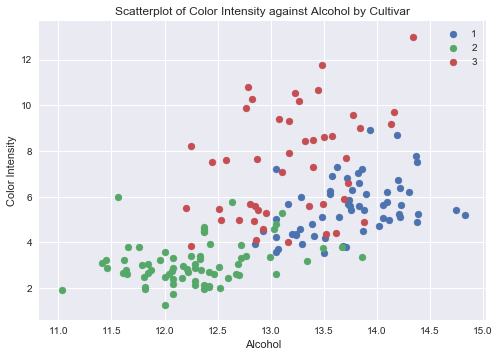

In [4]:
groups = sd.groupby("cultivar")
for name, group in groups:
    plt.scatter(group.alco, group.color_int, label = name)
plt.title("Scatterplot of Color Intensity against Alcohol by Cultivar")
plt.xlabel("Alcohol")
plt.ylabel("Color Intensity")
plt.legend()
plt.show()

# Logistic

In [5]:
X = sd.loc[:, ['alco', 'malic', 'tot_phen', 'color_int']].values
y = sd.cultivar.values

In [75]:
clf_mlog = KFold(n_splits=4, shuffle=True, random_state=22)
tuned_parameters = [{
    'penalty': ['l2'],
    'C': np.linspace(0.001, 0.8, 50)}
]

gs = GridSearchCV(LogisticRegression(multi_class='multinomial',solver = 'newton-cg'),tuned_parameters, scoring = "neg_mean_squared_error", cv = clf_mlog)

In [76]:
gs.fit(X, y)
gs.best_params_

{'C': 0.27820408163265309, 'penalty': 'l2'}

In [77]:
print("Minimized overall MSE is:{}".format(-gs.best_score_))

Minimized overall MSE is:0.06818181818181818


Note that currently multinomial logistic regression is not supported by L1 penalty.

# Random Forest

In [73]:
tuned_parameters = [{
    'max_depth':np.linspace(4, 20, 5).astype('int'),
    'n_estimators':[100,150, 200,250],
    'min_samples_leaf':np.linspace(5, 20, 5).astype('int')}
]
best_score = 0
for g in ParameterGrid(tuned_parameters):
    rf = RandomForestClassifier(oob_score = True, bootstrap = True,random_state=22, **g)
    rf.fit(X,y)
    
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

In [89]:
g

{'max_depth': 20, 'min_samples_leaf': 20, 'n_estimators': 250}

In [90]:
print("Minimized overall MSE is:{}".format(1-best_score))

Minimized overall MSE is:0.06818181818181823


# SVM

In [92]:
clf_svm = KFold(n_splits=4, shuffle=True, random_state=22)
tuned_parameters = [{
    'gamma':np.linspace(0.001, 5, 20),
    'C': np.linspace(0.001, 5, 20)}
]

gs_svm = GridSearchCV(SVC(kernel='rbf'),tuned_parameters, scoring = "neg_mean_squared_error", cv = clf_svm)

In [93]:
gs_svm.fit(X, y)
gs_svm.best_params_

{'C': 1.0534210526315788, 'gamma': 1.5796315789473683}

In [94]:
print("Minimized overall MSE is:{}".format(-gs_svm.best_score_))

Minimized overall MSE is:0.05113636363636364


# Neural Network

In [85]:
clf_mlp = KFold(n_splits=4, shuffle=True, random_state=22)
tuned_parameters = [{
    "activation": np.array(['identity', 'logistic', 'tanh', 'relu']),
    "hidden_layer_sizes": [50, 100, 150, 200, 300, 350],
    "alpha": np.linspace(0.1, 0.8, 10)
}]
gs_nn = GridSearchCV(MLPClassifier(random_state = 25, solver = 'lbfgs'),tuned_parameters, scoring = "neg_mean_squared_error", cv = clf_mlp)

In [86]:
gs_nn.fit(X, y)
gs_nn.best_params_

{'activation': 'relu', 'alpha': 0.33333333333333337, 'hidden_layer_sizes': 200}

In [87]:
print("Minimized overall MSE is:{}".format(-gs_nn.best_score_))

Minimized overall MSE is:0.05113636363636364


In [95]:
mse = pd.DataFrame({
    "Logistic": -gs.best_score_,
    "SVM":-gs_svm.best_score_,
    "Random Forest":1-best_score,
    "Neural Network": -gs_nn.best_score_
}, index = [0])
mse

,Logistic,Neural Network,Random Forest,SVC
0,0.068182,0.051136,0.068182,0.051136


MLPclassifier and SVM achieve the smallest MSE of 0.051136. Therefore, these two are the best predictors. Actually, 